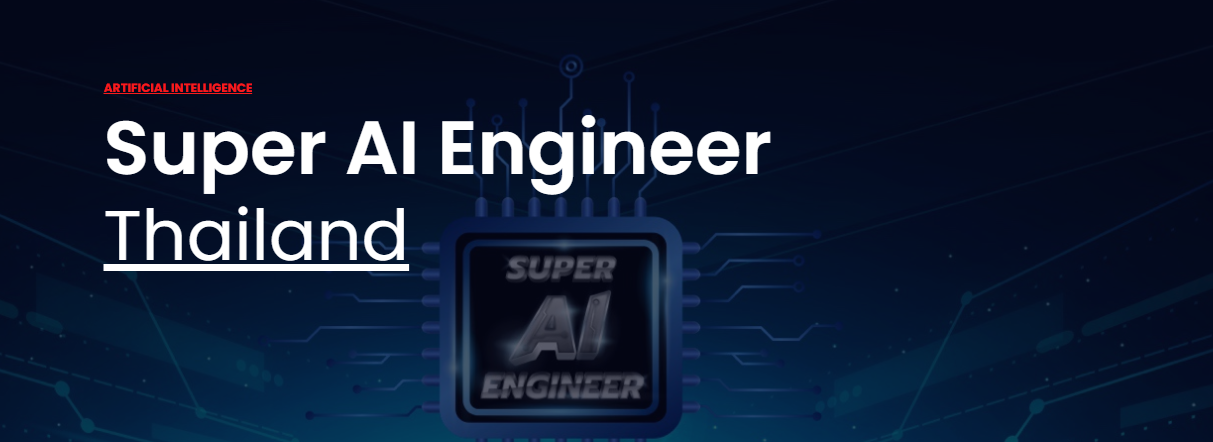

#Demo RAFT
#เขียนโดย 22p27c0357-ทัศนัย-Kideee-Super AI (บ้าน Kidee)
tuchsanai@gmail.com

In [1]:
!gdown --id 1nJreyqkk7pIp_TQym9hbABtWlvVB2THO
!unzip -q *.zip

Downloading...
From: https://drive.google.com/uc?id=1nJreyqkk7pIp_TQym9hbABtWlvVB2THO
To: /content/raft-pytorch.zip
46.1MB [00:00, 50.2MB/s]


In [2]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from glob import glob
from PIL import Image
from tqdm import tqdm

In [3]:
sys.path.append('raft-pytorch/')


from raft.core.raft import RAFT
from raft.core.utils import flow_viz
from raft.core.utils.utils import InputPadder
from raft.config import RAFTConfig

config = RAFTConfig(
    dropout=0,
    alternate_corr=False,
    small=False,
    mixed_precision=False
)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

weights_path = 'raft-sintel.pth'

ckpt = torch.load(weights_path, map_location=device)

model = RAFT(config)
model.to(device)
model.load_state_dict(ckpt)

device: cpu


<All keys matched successfully>

In [8]:
image_files = glob('raft/demo-frames/*.png')
image_files = sorted(image_files)

print(f'Found {len(image_files)} images')
print(sorted(image_files))

Found 10 images
['raft/demo-frames/frame_0016.png', 'raft/demo-frames/frame_0017.png', 'raft/demo-frames/frame_0018.png', 'raft/demo-frames/frame_0019.png', 'raft/demo-frames/frame_0020.png', 'raft/demo-frames/frame_0021.png', 'raft/demo-frames/frame_0022.png', 'raft/demo-frames/frame_0023.png', 'raft/demo-frames/frame_0024.png', 'raft/demo-frames/frame_0025.png']


In [9]:
def load_image(imfile, device):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()

    return img[None].to(device)


def viz(img1, img2, flo):
    img1 = img1[0].permute(1,2,0).cpu().numpy()
    img2 = img2[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    ax1.set_title('input image1')
    ax1.imshow(img1.astype(int))
    ax2.set_title('input image2')
    ax2.imshow(img2.astype(int))
    ax3.set_title('estimated optical flow')
    ax3.imshow(flo)
    plt.show()

0it [00:00, ?it/s]

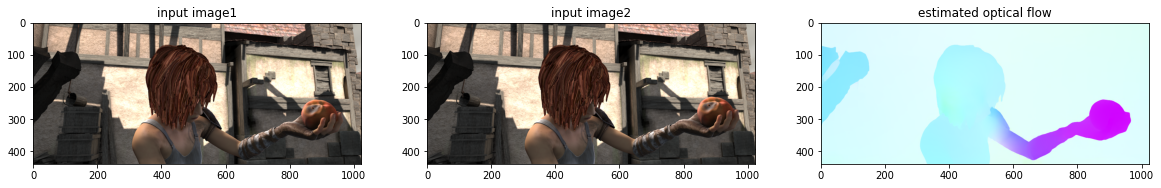

1it [00:25, 25.35s/it]

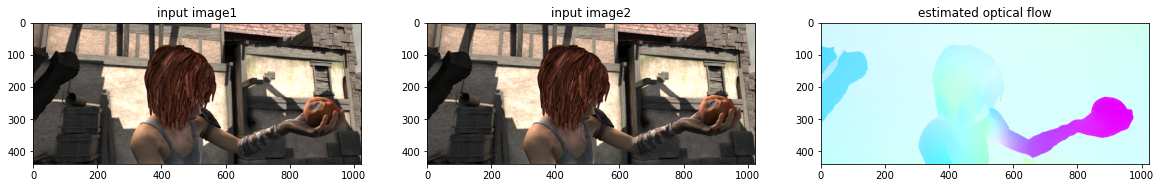

2it [00:50, 25.21s/it]

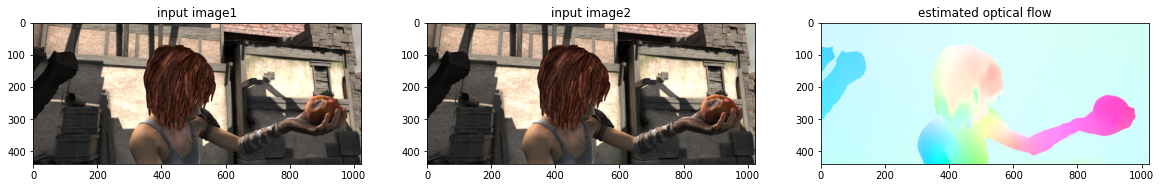

3it [01:14, 25.06s/it]

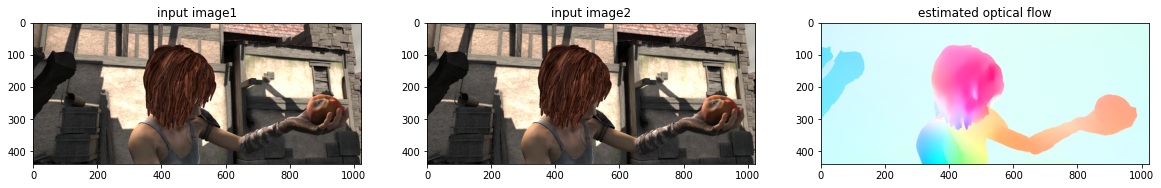

4it [01:39, 25.02s/it]

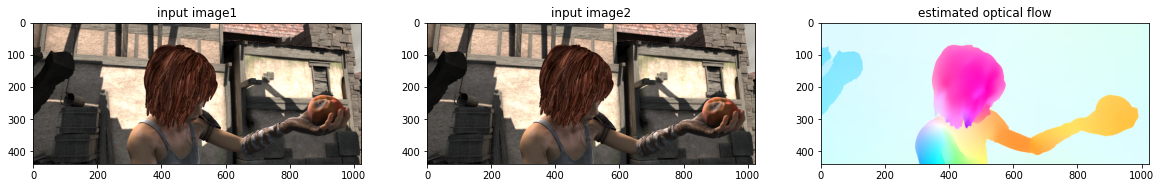

5it [02:04, 24.95s/it]

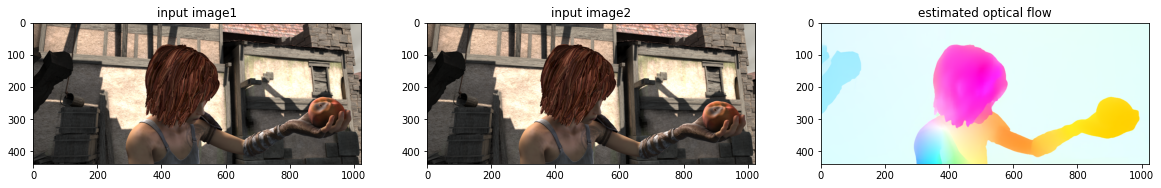

6it [02:29, 24.92s/it]

KeyboardInterrupt: ignored

In [10]:
model.eval()
n_vis = 10

for file1, file2 in tqdm(zip(image_files[:n_vis], image_files[1:1+n_vis])):
    image1 = load_image(file1, device)
    image2 = load_image(file2, device)

 
    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)
    
    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

    viz(image1, image2, flow_up)


#เปรียบเทียบกับ Open CV

In [18]:
def viz_cv2(img1, img2, flo):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    ax1.set_title('input image1')
    ax1.imshow(img1.astype(int))
    ax2.set_title('input image2')
    ax2.imshow(img2.astype(int))
    ax3.set_title('estimated optical flow')
    ax3.imshow(flo)
    plt.show()


0it [00:00, ?it/s]

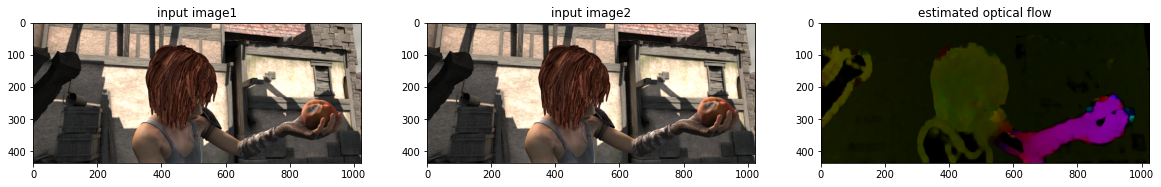


1it [00:00,  1.17it/s]

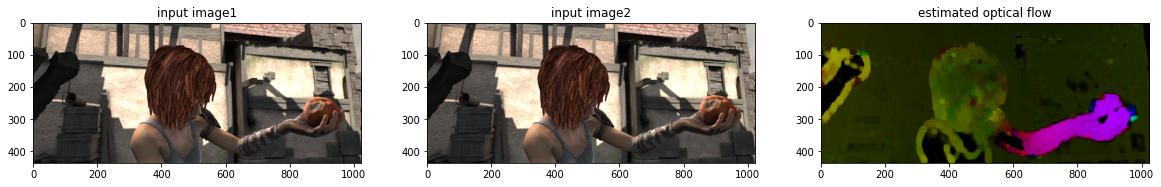


2it [00:01,  1.14it/s]

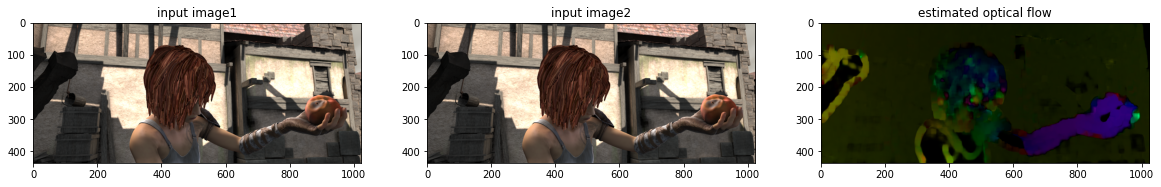


3it [00:02,  1.12it/s]

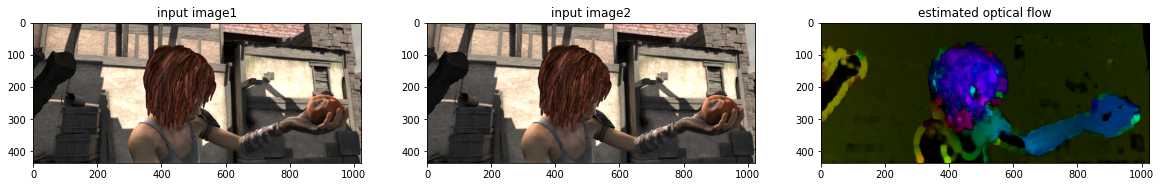


4it [00:03,  1.10it/s]

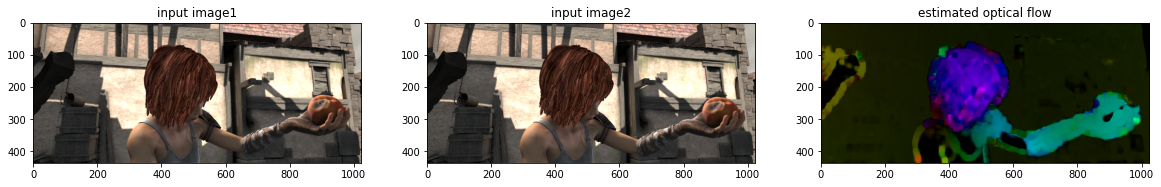


5it [00:04,  1.05it/s]

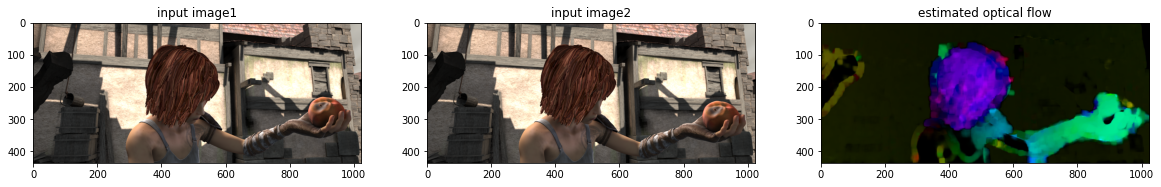


6it [00:05,  1.06it/s]

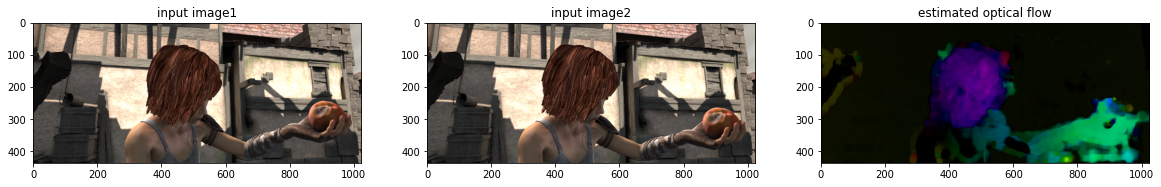


7it [00:06,  1.05it/s]

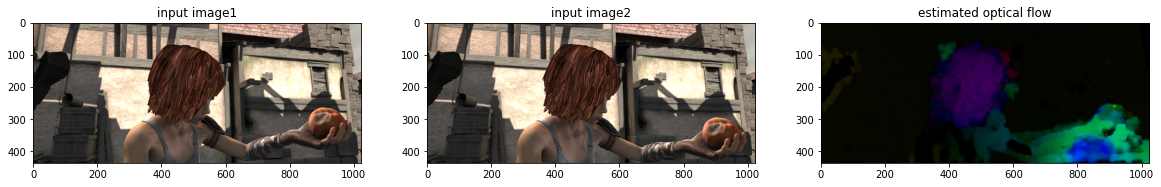


8it [00:07,  1.05it/s]

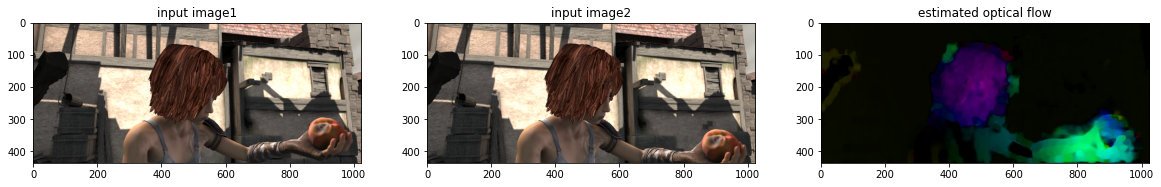


9it [00:08,  1.05it/s]


In [25]:
import cv2
import numpy as np


for file1, file2 in tqdm(zip(image_files[:n_vis], image_files[1:1+n_vis])):
    
    img1 = cv2.imread(file1) 
    img2 = cv2.imread(file2) 

    hsv = np.zeros_like(img1)
    hsv[...,1] = 255

    img1_gray= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY) 
    img2_gray= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY) 

    flow = cv2.calcOpticalFlowFarneback(img1_gray,img2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

 

    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    viz_cv2( cv2.cvtColor( img1,cv2.COLOR_BGR2RGB ) , cv2.cvtColor( img2, cv2.COLOR_BGR2RGB ), rgb) 
